How to run: <br> Simply run all the code blocks sequentially.

In [ ]:
#linking Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#install python_mnist

!pip install python_mnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#load MINST images

from mnist import MNIST
import numpy as np

mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_label = np.array(test_label, dtype='short')

#add small random noise to avoid matrix singularity
train_data += np.random.normal(0,0.0001,train_data.shape) 

print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [ ]:
# prepare digits '7' and '9' for logisic regression

digit_train_index = np.logical_or(train_label == 7, train_label == 9)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 7, test_label == 9)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# add a constant column of '1' to accomodate the bias (see the margin note on page 107)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1), dtype=X_train.dtype)))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1), dtype=X_test.dtype)))

# converge labels: '7' => -1, '9' => +1
CUTOFF = 8 # any number between '7' and '9'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

In [ ]:
# solve MCE using mini-batch gradient descent 
import numpy as np

class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs, training_mode):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs
    self.training_mode = training_mode

# sigmoid for numpy arrays
def sigmoid(x):
  return 1/(1 + np.exp(-x))

# X[N,d]: training features; y[N]: training targets; 
# X2[N,d]: test features; y2[N]: test targets;  
# op: hyper-parameters for optimzer 
#
# Note: X2 and y2 are not used in training
#       but only for computting the learning curve B
#
def MCE_gd(X, y, X2, y2, op):
  n = X.shape[0]            # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  mode = op.training_mode
  errorsA = np.zeros(op.max_epochs)
  errorsB = np.zeros(op.max_epochs)
  errorsC = np.zeros(op.max_epochs)

  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      ###############################################################################################################################
      #################################################### MODIFIED CODE HERE #######################################################
      ###############################################################################################################################

      # vectorization to compute gradients for a whole mini-batch (calculated from project report p.3)
      # w_grad = X_batch.T @ (y_batch * sigmoid(y_batch * (X_batch @ w)) * sigmoid(y_batch * (X_batch @ w)) - y_batch * sigmoid(y_batch * (X_batch @ w))) / X_batch.shape[0]
      if mode=='mce':
        w_grad = X_batch.T @ (-y_batch * sigmoid(-y_batch * (X_batch @ w)) * sigmoid(y_batch * (X_batch @ w))) / X_batch.shape[0]
      elif mode=='reg':
        w_grad = X_batch.T @ (y_batch * sigmoid(y_batch * (X_batch @ w)) - y_batch) / X_batch.shape[0] 
      w -= lr * w_grad 

    # for learning curve C
    errorsC[epoch] = - np.mean(np.log( sigmoid(y * (X @ w))) )

    # for learning curve A
    predict = np.sign(X @ w)
    errorsA[epoch] = np.count_nonzero(np.equal(predict,y))/y.size 

    # for learning curve B
    predict2 = np.sign(X2 @ w)
    errorsB[epoch] = np.count_nonzero(np.equal(predict2,y2))/y2.size

    lr *= op.annealing_rate

  print(f'epoch={epoch}: the MCE loss is C={errorsC[epoch]:.3f} (A={errorsA[epoch]:.3f},B={errorsB[epoch]:.3f})')
  return w, errorsA, errorsB, errorsC

epoch=99: the MCE loss is C=0.165 (A=0.956,B=0.961)


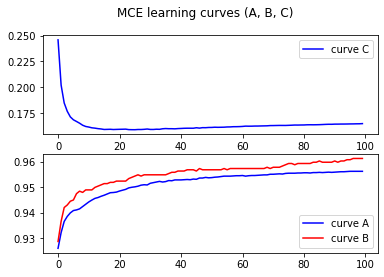

In [ ]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.025, annealing_rate=0.99, batch_size=50, max_epochs=100, training_mode='mce')

w, A, B, C = MCE_gd(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('MCE learning curves (A, B, C)')
ax[0].plot(C, 'b')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

epoch=99: the MCE loss is C=0.107 (A=0.964,B=0.964)


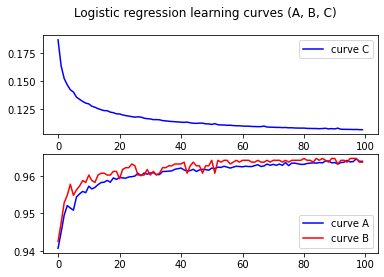

In [ ]:
# compare results with that of logistic regression

op = Optimizer(lr=0.05, annealing_rate=0.99, batch_size=50, max_epochs=100, training_mode='reg')

w, A, B, C = MCE_gd(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('Logistic regression learning curves (A, B, C)')
ax[0].plot(C, 'b')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])